In [5]:
import os
import sys
import json
import traceback
import argparse
import time

import tensorflow as tf

import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest import ConcurrencyLimiter
from hyperopt import hp

# from model import FCN_model
# from generator import Generator
# from callbacks import create_callbacks
# import logger as Logger

# logger = Logger.get_logger('hyper_fcn', './logs/training')

In [6]:
config = {
	"lr": hp.choice("lr", [0.0001, 0.001, 0.01, 0.1]),
	"batch_size": hp.choice("batch_size", [8, 16, 32, 64]), 
	"use_contrast": hp.choice("use_contrast", ["True", "False"]),
	"contrast_factor": hp.choice("contrast_factor", [0.1, 0.2, 0.3, 0.4]),
	"use_rotation": hp.choice("use_rotation", ["True", "False"]),
	"rotation_factor": hp.choice("rotation_factor", [0.1, 0.2, 0.3, 0.4]),
	"use_flip": hp.choice("use_flip", ["True", "False"]),
	"flip_mode": hp.choice("flip_mode", ["horizontal", "vertical"]),
	"dropout_rate": hp.choice("dropout_rate", [0.1, 0.2, 0.3, 0.4, 0.5]),
	"conv_block1_filters": hp.choice("conv_block1_filters", [32, 64, 128, 256, 512]),
	"conv_block2_filters": hp.choice("conv_block2_filters", [32, 64, 128, 256, 512]),
	"conv_block3_filters": hp.choice("conv_block3_filters", [32, 64, 128, 256, 512]),
	"conv_block4_filters": hp.choice("conv_block4_filters", [32, 64, 128, 256, 512]),
	"conv_block5_filters": hp.choice("conv_block5_filters", [32, 64, 128, 256, 512]),
	"fc_layer_type": hp.choice("fc_layer_type", ["dense", "convolution"]),
	"pool_type": hp.choice("pool_type", ["max", "average"]),
	"fc1_units": hp.choice("fc1_units", [32, 64, 128, 256, 512])
}

In [7]:
def FCN_model(config, len_classes=5):
    
    input = tf.keras.layers.Input(shape=(None, None, 3))

    # Adding data augmentation layers
    x = input

    # You can create a fixed number of convolutional blocks or 
    # You can also use a loop if number of layers is also a hyperparameter
    x = tf.keras.layers.Conv2D(filters=config['conv_block1_filters'], kernel_size=3, strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters=config['conv_block2_filters'], kernel_size=3, strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    if config['fc_layer_type'] == 'dense':
        if config['pool_type'] == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)
        else:
            x = tf.keras.layers.GlobalAveragePooling2D()(x)

        # Fully connected layer 1
        x = tf.keras.layers.Dense(units=config['fc1_units'])(x)
        x = tf.keras.layers.Dropout(config['dropout_rate'])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        # Fully connected layer 2
        x = tf.keras.layers.Dense(units=len_classes)(x)
        x = tf.keras.layers.Dropout(config['dropout_rate'])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        predictions = tf.keras.layers.Activation('softmax')(x)

    else:
        # Some other FC layer configuration
        # .
        # .
        # .

     model = tf.keras.Model(inputs=input, outputs=predictions)
     return model

In [8]:
# logger.info("Initializing ray")
ray.init(configure_logging=False)

# logger.info("Initializing ray search space")
search_space, intial_best_config = create_search_space()

# logger.info("Initializing scheduler and search algorithms")
# Use HyperBand scheduler to earlystop unpromising runs
scheduler = AsyncHyperBandScheduler(time_attr='training_iteration',
					metric="val_loss",
					mode="min",
					grace_period=10)

# Use bayesian optimisation with TPE implemented by hyperopt
search_alg = HyperOptSearch(search_space,
				metric="val_loss",
				mode="min",
				points_to_evaluate=intial_best_config)

# We limit concurrent trials to 2 since bayesian optimisation doesn't parallelize very well
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)

In [ ]:
class TuneReporter(tf.keras.callbacks.Callback):
    """Tune Callback for Keras."""

    def __init__(self, reporter=None, freq="epoch", logs=None):
        """Initializer.
        Args:
            freq (str): Sets the frequency of reporting intermediate results.
        """
        self.iteration = 0
        logs = logs or {}
        self.freq = freq
        super(TuneReporter, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        from ray import tune
        logs = logs or {}
        if not self.freq == "epoch":
            return
        self.iteration += 1
        if "acc" in logs:
            tune.report(keras_info=logs, val_loss=logs['val_loss'], mean_accuracy=logs["acc"])
        else:
            tune.report(keras_info=logs, val_loss=logs['val_loss'], mean_accuracy=logs.get("accuracy"))


In [ ]:
class Trainable:
    def __init__(self, train_dir, val_dir, snapshot_dir, final_run=False):
        # Initializing state variables for the run
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.final_run = final_run
        self.snapshot_dir = snapshot_dir

    def train(self, config, reporter=None):
        # If you get out of memory error try reducing the maximum batch size
        train_generator = Generator(self.train_dir, config['batch_size'])
        val_generator = Generator(self.val_dir, config['batch_size'])

        # Create FCN model
        model = FCN_model(config, len_classes=len(train_generator.classes))

        # Compile model with losses and metrics
        model.compile(optimizer=tf.keras.optimizers.Nadam(lr=config['lr']),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
        
        # Create callbacks to be used during model training
        callbacks = create_callbacks(self.final_run, self.snapshot_dir)

        logger.info("Starting model training")
        # Start model training
        history = model.fit(train_generator,
                            steps_per_epoch=len(train_generator),
                            epochs=100,
                            callbacks=callbacks,
                            validation_data=val_generator,
                            validation_steps=len(val_generator)
                            )
        return history

logger.info("Initializing ray Trainable")
# Initialize Trainable for hyperparameter tuning
trainer = Trainable(args.train_dir, args.val_dir, args.snapshot_dir, final_run=False)

logger.info("Starting hyperparameter tuning")
analysis = tune.run(trainer.train, 
                    verbose=1, 
                    num_samples=num_samples,
                    search_alg=search_alg,
                    scheduler=scheduler,
                    raise_on_failed_trial=False,
                    resources_per_trial={"cpu": 16, "gpu": 2}
                    )

best_config = analysis.get_best_config(metric="val_loss", mode='min')
logger.info(f'Best config: {best_config}')

In [12]:

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

shared_dir = '/Users/prateek/Desktop/ML/Major/aug'
input_shape = [32, 32]
batch = 32

training_set = image_dataset_from_directory(shared_dir,
                                            validation_split=0.2,
                                            subset="training",
                                            batch_size=batch,
                                            seed=1,
                                            color_mode='rgb',
                                            image_size=input_shape)

val_dataset = image_dataset_from_directory(shared_dir,
                                            validation_split=0.2,
                                            subset="validation",
                                            batch_size=batch,
                                            seed=1,
                                            color_mode='rgb',
                                            image_size=input_shape)

input_shape.append(3)
print(input_shape)

Found 188411 files belonging to 2 classes.
Using 150729 files for training.
Found 188411 files belonging to 2 classes.
Using 37682 files for validation.
[32, 32, 3]


In [13]:
import tensorflow as tf

from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

def data_agument(image):
    datagen = ImageDataGenerator(featurewise_center=True,rotation_range=(0-30),width_shift_range=0.2,
                             height_shift_range=0.2,brightness_range=[0.5,1.5],
                             shear_range=0.2, zoom_range=0.2,channel_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True,fill_mode='nearest')
    
    it = datagen.flow(expand_dims(image, 0), batch_size=1)
    
    images = []
    for x in range(10):
      batch = it.next()
      img = batch[0].astype('uint8')
      images.append(img)
    return images


In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# for images, labels in training_set.take(1):
#     cv2_imshow(images[0].numpy().astype('int32'))
#     plt.figure(figsize=(12, 12))
#     first_image = images[0]
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         augmented_image = data_augmentation(
#             tf.expand_dims(first_image, 0)
#         )
#         plt.imshow(augmented_image[0].numpy().astype("int32"))
#         plt.axis("off")

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras import Model, Input
from keras.applications.xception import Xception, preprocess_input
from keras.callbacks import LearningRateScheduler
import numpy as np

epochs = 100
dropout_rate = 0.2
len_classes = 5
images = []

inputs = Input(shape=input_shape)
x = preprocess_input(inputs)
x = Conv2D(64, kernel_size=(3, 3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, kernel_size=(4, 4),activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
model.summary()

optimizer = tf.keras.optimizers.Adam(lr=0.01)
optimizer.learning_rate.assign(0.1)

def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 20
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=keras.metrics.BinaryAccuracy())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 32, 32, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 32, 32, 3)        0         
 bda)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                           

In [25]:

history = model.fit(training_set, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
4710/4711 [============================>.] - ETA: 0s - loss: 0.2257 - binary_accuracy: 0.9142

2022-03-24 17:12:46.343294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4711/4711 [==============================] - 75s 16ms/step - loss: 0.2257 - binary_accuracy: 0.9142 - val_loss: 0.1766 - val_binary_accuracy: 0.9405 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
4711/4711 [==============================] - 75s 16ms/step - loss: 0.1698 - binary_accuracy: 0.9406 - val_loss: 0.1630 - val_binary_accuracy: 0.9410 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
4711/4711 [==============================] - 75s 16ms/step - loss: 0.1617 - binary_accuracy: 0.9434 - val_loss: 0.1588 - val_binary_accuracy: 0.9436 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
4711/4711 [==============================] - 75s 16ms/step - loss: 0.1578 - binary_accuracy: 0.9451 - val_loss: 0.1587 - val_binary_accuracy: 0.9445 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.00100000004749745

loss
binary_accuracy
val_loss
val_binary_accuracy
lr


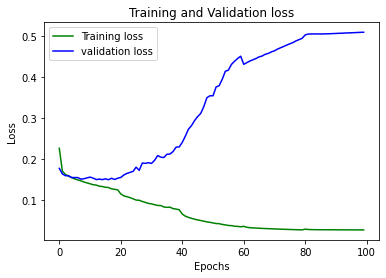

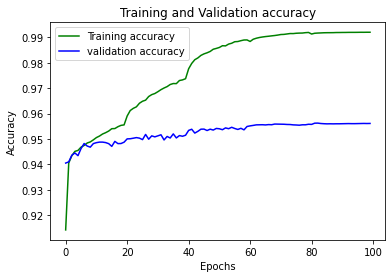

In [26]:
import matplotlib.pyplot as plt

for key in history.history.keys():
    print(key)
loss_train = history.history['loss']
loss_val = history.history['val_loss']
no_epochs = range(epochs)
plt.plot(no_epochs, loss_train, 'g', label='Training loss')
plt.plot(no_epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['binary_accuracy']
loss_val = history.history['val_binary_accuracy']
plt.plot(no_epochs, loss_train, 'g', label='Training accuracy')
plt.plot(no_epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.BinaryAccuracy())
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# rm -rf logs
%load_ext tensorboard
log_folder = 'logs'
callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
# rm -rf logs
%load_ext tensorboard
log_folder = 'logs'
callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]
model.fit(training_set, epochs=epochs,validation_data=val_dataset,callbacks=callbacks)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/100
4711/4711 [==============================] - 75s 16ms/step - loss: 0.0252 - binary_accuracy: 0.9924 - val_loss: 0.5137 - val_binary_accuracy: 0.9559
Epoch 2/100
4711/4711 [==============================] - 76s 16ms/step - loss: 0.0250 - binary_accuracy: 0.9925 - val_loss: 0.5150 - val_binary_accuracy: 0.9560
Epoch 3/100
4711/4711 [==============================] - 76s 16ms/step - loss: 0.0249 - binary_accuracy: 0.9925 - val_loss: 0.5183 - val_binary_accuracy: 0.9559
Epoch 4/100
4711/4711 [==============================] - 77s 16ms/step - loss: 0.0247 - binary_accuracy: 0.9926 - val_loss: 0.5204 - val_binary_accuracy: 0.9559
Epoch 5/100
4711/4711 [==============================] - 76s 16ms/step - loss: 0.0246 - binary_accuracy: 0.9926 - val_loss: 0.5218 - val_binary_accuracy: 0.9558
Epoch 6/100
4711/4711 [==============================] - 77s 16ms/step - loss: 0.0244 - binary_accuracy: 